In [44]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy
import networkx as nx
from pyvis.network import Network
import ctypes
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss


# Generating data

In [161]:
n,k = 2500,2
X = numpy.random.uniform(low=-100,high=100,size=(n,k))

In [162]:
y=((X[:,0]**2 + X[:,1]**2)**.5 < 60).reshape(-1,1)

In [163]:
X,X_test,y,y_test = train_test_split(X,y)

In [164]:
X.shape,X_test.shape,y.shape,y_test.shape

((1875, 2), (625, 2), (1875, 1), (625, 1))

In [49]:
def PlotData(X,y):
    plt.scatter(x=X[:,0],y=X[:,1],c=y)    

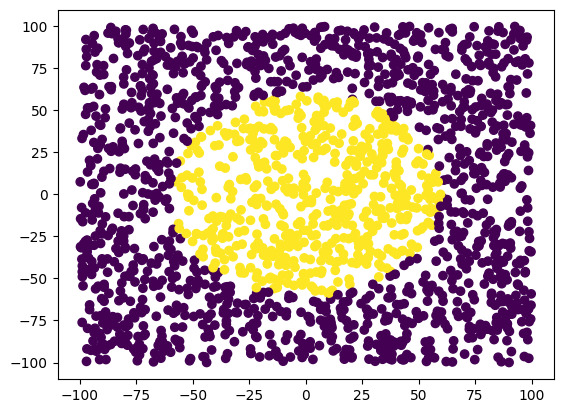

In [50]:
PlotData(X,y)

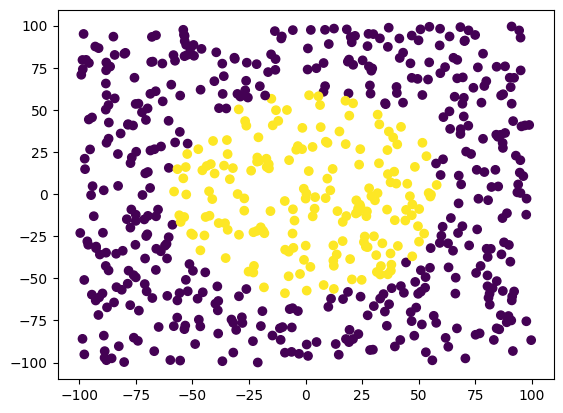

In [51]:
PlotData(X_test,y_test)

# Network Architechture
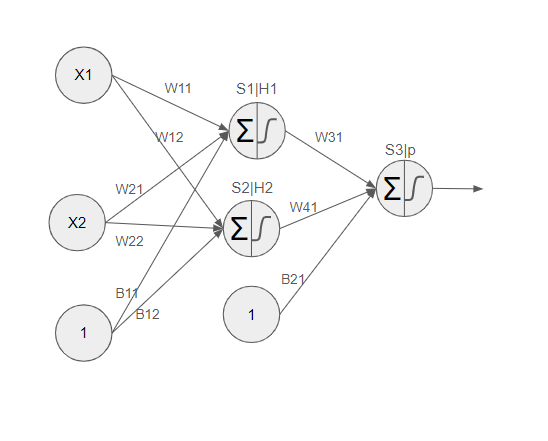

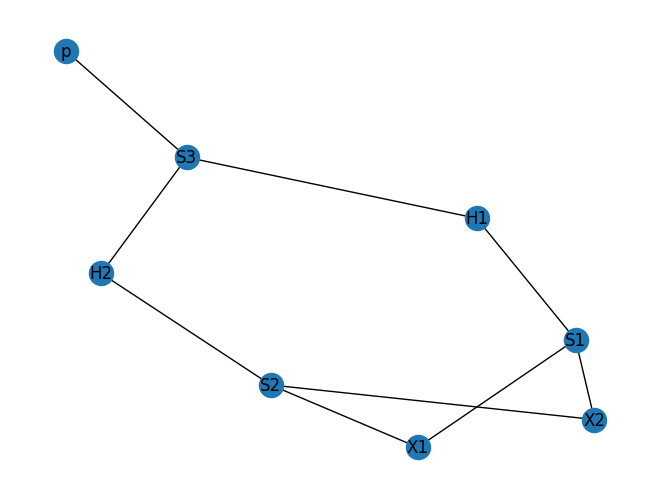

In [52]:
graph = {
    'S1':['X1','X2'],
    'S2':['X1','X2'],
    'H1':['S1'],
    'H2':['S2'],
    'S3':['H1','H2'],
    'p':['S3']
    
}
G = nx.Graph(graph)
nx.draw(G,with_labels=True)

In [53]:
ModelGraph = nx.Graph()

class GraphManager:
    def __init__(self):
        ...
    def add_to_graph(self,val):
        inids,out = val
        outid = id(out)
        if not hasattr(inids,'__iter__'):
            inids = [inids]
        for inid in inids :
            ModelGraph.add_edges_from([(inid,outid)])
        return outid,out
    def draw(engine=None,params={}):
        if not engine:
            nx.draw(ModelGraph,with_labels=True)
        elif engine == 'pyviz':
            pynet = Network(**params)
            pynet.from_nx(ModelGraph)
            pynet.barnes_hut()
            #for node in pynet.nodes:
            #    node["detail"] = ctypes.cast(node['id'], ctypes.py_object).value
            return pynet.show("ModelGraph.html")

def zeros(n_in,n_out):
    return numpy.zeros((n_in+1,1))
    
class Σ(GraphManager):
    def __init__(self,In,init_method=zeros,n_out=None):
        super().__init__()
        self.In = In
        self.init_method=init_method
        self.layer_nout = n_out
    def eval(self):
        if not hasattr(self,'w'):
            self.w = self.init_method(self.In[1].shape[1],self.layer_nout)
            self.b = numpy.ones((self.In[1].shape[0],1))
        out = lambda : numpy.c_[self.In[1],self.b].dot(self.w)
        self.outid,self.out = self.add_to_graph((self.In[0],out())) 
        return (self.outid,self.out)
    def prime(self):
        self.pr = numpy.c_[self.In[1],self.b]
        return self.pr
    def update(self,Δnext):
        self.Δ = (self.prime().T.dot(Δnext)).reshape(-1,1)
        self.Δ /= self.In[1].shape[0]
        self.w -= self.Δ
        return self.Δ[:-1,:]

In [407]:
class σ(GraphManager):
    def __init__(self,In=None):
        super().__init__()
        self.In = In
    def eval(self):
        out = lambda: 1/(1+numpy.exp(-self.In[1]))
        self.outid,self.out = self.add_to_graph((self.In[0],out())) 
        return (self.outid,self.out)
    def prime(self):
        self.p = self.out*(1-self.out)
        return self.p
    def update(self,Δnext):
        self.Δ = Δnext*self.prime()
        return self.Δ    
class Softmax(GraphManager):#normalized exponential
    def __init__(self,In=None):
        super().__init__()
        self.In = In
    def eval(self):
        out = lambda: numpy.exp(self.In[1])/numpy.exp(self.In[1]).sum(axis=1).reshape(-1,1)
        self.outid,self.out = self.add_to_graph((self.In[0],out())) 
        return (self.outid,self.out)
    def prime(self):
        self.p = self.out*(1-self.out)
        return self.p
    def update(self,Δnext):
        self.Δ = Δnext*self.prime()
        return self.Δ    

In [278]:
s = Σ(In=(id(X),X))
s.eval()

(140215590463952,
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]))

In [279]:
z = σ(s.eval())
z.eval()

(140215590468560,
 array([[0.5],
        [0.5],
        [0.5],
        ...,
        [0.5],
        [0.5],
        [0.5]]))

In [280]:
z = Softmax(s.eval())
z.eval()

(140215590467312,
 array([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]))

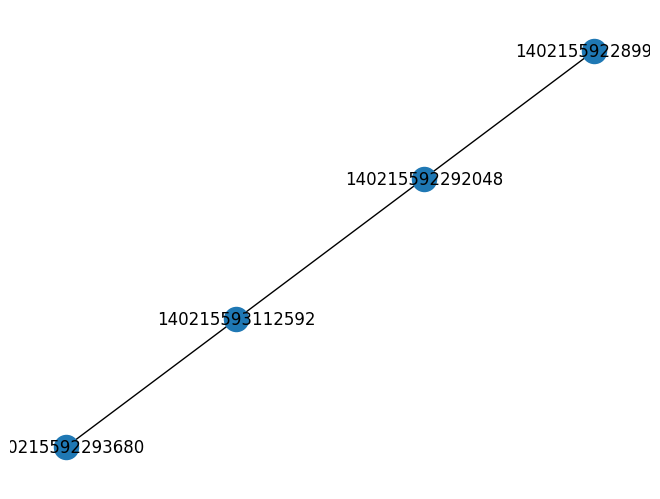

In [58]:
GraphManager.draw()

In [505]:
class fullyconnected(GraphManager):
    def __init__(self,n_out,init_method=zeros,In=None):
        super().__init__()
        self.n_out = n_out
        self.__In = [Σ((id(In),In),init_method,self.n_out)]*self.n_out
    @property
    def In(self):
        return self.__In
    @In.setter
    def In(self,v):
        v = dict(v)
        for s in self.__In:
            s.In = (tuple(v.keys()),numpy.concatenate(list(v.values()),axis=1))
    def __len__(self):
        return len(self.In)
    def eval(self):
        self.out = [s.eval() for s in self.In]
        return self.out
    def update(self,Δnext):
        self.Δ =  {v.In[0] : v.update(Δnext[v.outid]) for v in self.In }
        oldks = list(self.Δ)
        for k in oldks:
            if hasattr(k,'__iter__'):
                v = self.Δ[k]
                del(self.Δ[k])
                self.Δ.update(dict(zip(k,v)))
        return self.Δ    
class activation(GraphManager):
    def __init__(self,func=σ,loop=True):
        super().__init__()
        self.func = func
        self.loop = loop
    @property
    def In(self):
        return self.__In
    @In.setter
    def In(self,v):
        if self.loop:
            self.__In = [self.func(s) for s in v]
        else:
            v = dict(v)
            k,v=tuple(v.keys()),numpy.concatenate(list(v.values()),axis=1)
            self.__In = [self.func((k,v))]
    def __len__(self):
        return len(self.In)
    def eval(self):
        self.out = [act.eval() for act in self.In]
        return self.out
    def update(self,Δnext) :
        self.Δ = {act.In[0] : act.update(Δnext[act.outid]) for act in self.In }
        if not self.loop:
             keys = list(self.Δ.keys())[0]
             self.Δ = {k : self.Δ[keys][:,ix].reshape(-1,1) for ix,k in enumerate(keys)}
        return self.Δ        

# Backpropagation

## Sequential architecture

In [313]:
class Sequential:
    def __init__(self,steps):
        self.steps = steps
    def eval(self):
        self.out  = self.steps[0].eval()
        for step in self.steps[1:]:
            step.In = self.out
            step.eval()
            self.out = step.out
        return self.out
    def update(self,Δnext):
        self.Δnext = Δnext
        for step in self.steps[::-1]:
            self.Δnext = step.update(self.Δnext)
        return self

## Loss functions

In [425]:
class binaryCrossEntropy:
    def __init__(self,y,p):
        self.y = y
        self.p = p.clip(1e-8)#for safety to avoid zero division error
    def eval(self):
        self.out = -(self.y*numpy.log(self.p) + (1-self.y)*numpy.log(1-self.p)).mean()
        return self.out
    def prime(self):
        self. pr = -(self.y/self.p - (1-self.y)/(1-self.p))
        return self.pr
class CrossEntropy:
    def __init__(self,y,p):
        self.y = y
        self.p = p.clip(1e-8)#for safety to avoid zero division error
    def eval(self):
        self.out = -(self.y*numpy.log(self.p)).sum()/self.p.shape[0] 
        return self.out
    def prime(self):
        self. pr = -(self.y/self.p )
        return self.pr
class MSE:
    def __init__(self,y,p):
        self.y = y
        self.p = p.clip(1e-8)#for safety to avoid zero division error
    def eval(self):
        self.out = ((self.y-self.p)**2).mean()
        return self.out
    def prime(self):
        self. pr = -2*(self.y-self.p)
        return self.pr

# Model Architecture

In [315]:
ModelGraph = nx.Graph()

Model = Sequential([

        fullyconnected(n_out=3,In=(X-X.mean())/X.std()),
])
Model.eval()

[(140215587223664,
  array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]])),
 (140215587223088,
  array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]])),
 (140215587220208,
  array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]))]

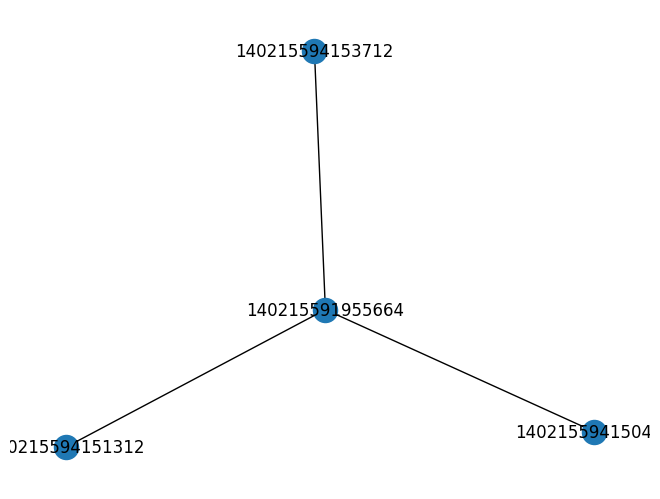

In [63]:
GraphManager.draw()

In [347]:
ModelGraph = nx.Graph()

Model = Sequential([

        fullyconnected(n_out=5,In=(X-X.mean())/X.std()),
        activation()
])
Model.eval()

[(140215596050128,
  array([[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]])),
 (140215596044368,
  array([[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]])),
 (140215596042160,
  array([[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]])),
 (140215596047536,
  array([[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]])),
 (140215596046480,
  array([[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]]))]

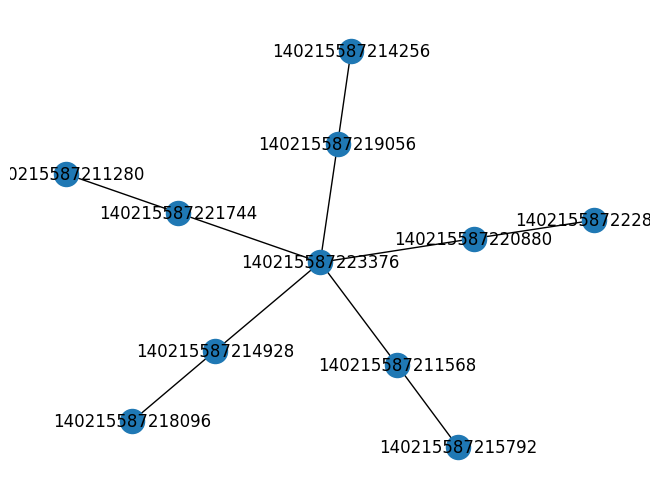

In [317]:
GraphManager.draw()

In [426]:
ModelGraph = nx.Graph()

Model = Sequential([

        fullyconnected(n_out=100,In=(X-X.mean())/X.std()),
        activation(),
        fullyconnected(10),
        activation(),
        fullyconnected(1),
        activation()
])
Model.eval()

[(140215595752912,
  array([[0.5],
         [0.5],
         [0.5],
         ...,
         [0.5],
         [0.5],
         [0.5]]))]

In [301]:
Model.steps[-1].In[0].In

[(140215597507248,
  array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]])),
 (140215597505808,
  array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]))]

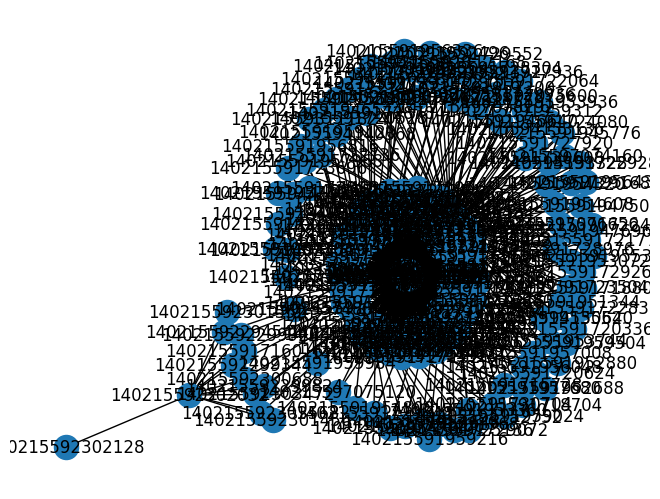

In [67]:
GraphManager.draw()

In [68]:
graphparams = {"bgcolor":"#222222", "font_color":"white","notebook":True}
GraphManager.draw(engine='pyviz',params=graphparams)

ModelGraph.html


# BackPropagation

## Loss function

In [490]:
L= binaryCrossEntropy(y,Model.eval()[0][1]) 
print('logloss=',L.eval())

logloss= 0.6931471805599453


In [494]:
ModelGraph = nx.Graph()

onehot = lambda y : y==numpy.unique(y)

Model = Sequential([

        fullyconnected(n_out=100,In=(X-X.mean())/X.std()),
        activation(),
        fullyconnected(10),
        activation(),
        fullyconnected(2),
        activation(func=Softmax,loop=False)
])
_,p = Model.eval()[0]
L= CrossEntropy(onehot(y),p) 
print('entropy=',L.eval())

entropy= 0.6931471805599453


## Propagating loss

In [495]:
α = 1e-3
Δ = {Model.steps[-1].out[0][0]:α*L.prime()}
Δ

{140215513642640: array([[-0.002, -0.   ],
        [-0.002, -0.   ],
        [-0.   , -0.002],
        ...,
        [-0.   , -0.002],
        [-0.   , -0.002],
        [-0.002, -0.   ]])}

In [72]:
Model.steps[-1]

In [73]:
Model.steps[-1].In,Model.steps[-1].out

([<__main__.σ at 0x7f867c600690>],
 [(140215592300688, array([[0.5],
          [0.5],
          [0.5],
          ...,
          [0.5],
          [0.5],
          [0.5]]))])

In [496]:
Δ = Model.steps[-1].update(Δ)
Δ

{140215513642256: array([[-0.0005, -0.    ],
        [-0.0005, -0.    ],
        [-0.    , -0.0005],
        ...,
        [-0.    , -0.0005],
        [-0.    , -0.0005],
        [-0.0005, -0.    ]]),
 140215513642352: array([[-0.0005, -0.    ],
        [-0.0005, -0.    ],
        [-0.    , -0.0005],
        ...,
        [-0.    , -0.0005],
        [-0.    , -0.0005],
        [-0.0005, -0.    ]])}

In [500]:
Model.steps[-2]

In [501]:
Model.steps[-2].In,Model.steps[-2].out

([<__main__.Σ at 0x7f867c3990d0>, <__main__.Σ at 0x7f867c3990d0>],
 [(140215513642256,
   array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]])),
  (140215513642352,
   array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]))])

In [502]:
Model.steps[-2].In[0].outid

140215513642352

In [504]:
Model.steps[-2].In[0].In[1].shape,Model.steps[-2].In[0].out.shape

((1875, 10), (1875, 1))

In [497]:
Δ = Model.steps[-2].update(Δ)
Δ

ValueError: operands could not be broadcast together with shapes (11,1) (22,1) (11,1) 

In [ ]:
Model.steps[-3]

In [450]:
Model.steps[-3].In,Model.steps[-3].In[0].outid

([<__main__.σ at 0x7f8675a653d0>,
 140215512574800)

In [451]:
Model.steps[-3].In[0].In 

(140215595752240,
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]))

In [452]:
Δ = Model.steps[-3].update(Δ)
Δ

{140215595752240: array([[-1.81333333e-05],
        [-1.81333333e-05],
        [-1.81333333e-05],
        ...,
        [-1.81333333e-05],
        [-1.81333333e-05],
        [-1.81333333e-05]]),
 140215595752144: array([[-1.81333333e-05],
        [-1.81333333e-05],
        [-1.81333333e-05],
        ...,
        [-1.81333333e-05],
        [-1.81333333e-05],
        [-1.81333333e-05]]),
 140215595752048: array([[-1.81333333e-05],
        [-1.81333333e-05],
        [-1.81333333e-05],
        ...,
        [-1.81333333e-05],
        [-1.81333333e-05],
        [-1.81333333e-05]]),
 140215595751952: array([[-1.81333333e-05],
        [-1.81333333e-05],
        [-1.81333333e-05],
        ...,
        [-1.81333333e-05],
        [-1.81333333e-05],
        [-1.81333333e-05]]),
 140215595751472: array([[-1.81333333e-05],
        [-1.81333333e-05],
        [-1.81333333e-05],
        ...,
        [-1.81333333e-05],
        [-1.81333333e-05],
        [-1.81333333e-05]]),
 140215595751280: array([[-1.8

In [ ]:
Model.steps[-4]

In [453]:
Model.steps[-4].In,Model.steps[-4].out

([<__main__.Σ at 0x7f867c9e1750>,
 [(140215595752240,
   array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]])),
  (140215595752144,
   array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]])),
  (140215595752048,
   array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]])),
  (140215595751952,
   array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]])),
  (140215595751472,
   array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]])),
  (140215595751280,
   array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]])),
  (140215595751376,
   array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]])),
  (140215512574992,
   array

In [454]:
Δ = Model.steps[-4].update(Δ)
Δ

{140215682080880: array([-9.06666667e-06]),
 140215682082800: array([-9.06666667e-06]),
 140215682076560: array([-9.06666667e-06]),
 140215587766064: array([-9.06666667e-06]),
 140215587750608: array([-9.06666667e-06]),
 140215587759728: array([-9.06666667e-06]),
 140215587762320: array([-9.06666667e-06]),
 140215587750032: array([-9.06666667e-06]),
 140215587764528: array([-9.06666667e-06]),
 140215587755120: array([-9.06666667e-06]),
 140215587759536: array([-9.06666667e-06]),
 140215587758576: array([-9.06666667e-06]),
 140215587763952: array([-9.06666667e-06]),
 140215586682416: array([-9.06666667e-06]),
 140215586678384: array([-9.06666667e-06]),
 140215586682608: array([-9.06666667e-06]),
 140215586683952: array([-9.06666667e-06]),
 140215586675984: array([-9.06666667e-06]),
 140215586679344: array([-9.06666667e-06]),
 140215586669072: array([-9.06666667e-06]),
 140215586672048: array([-9.06666667e-06]),
 140215586674832: array([-9.06666667e-06]),
 140215586684144: array([-9.0666

In [ ]:
len(Δ)

100

In [ ]:
Model.steps[-5]

In [ ]:
Model.steps[-5].In,Model.steps[-5].out

([<__main__.σ at 0x7fa991e7fd10>,
 [(140366272014992,
   array([[0.5],
          [0.5],
          [0.5],
          ...,
          [0.5],
          [0.5],
          [0.5]])),
  (140366272008560,
   array([[0.5],
          [0.5],
          [0.5],
          ...,
          [0.5],
          [0.5],
          [0.5]])),
  (140366272008272,
   array([[0.5],
          [0.5],
          [0.5],
          ...,
          [0.5],
          [0.5],
          [0.5]])),
  (140366272008080,
   array([[0.5],
          [0.5],
          [0.5],
          ...,
          [0.5],
          [0.5],
          [0.5]])),
  (140366272006640,
   array([[0.5],
          [0.5],
          [0.5],
          ...,
          [0.5],
          [0.5],
          [0.5]])),
  (140366272007984,
   array([[0.5],
          [0.5],
          [0.5],
          ...,
          [0.5],
          [0.5],
          [0.5]])),
  (140366272007888,
   array([[0.5],
          [0.5],
          [0.5],
          ...,
          [0.5],
          [0.5],
      

In [455]:
Δ = Model.steps[-5].update(Δ)
Δ

{140215590456272: array([[-2.26666667e-06],
        [-2.26666667e-06],
        [-2.26666667e-06],
        ...,
        [-2.26666667e-06],
        [-2.26666667e-06],
        [-2.26666667e-06]]),
 140215594145168: array([[-2.26666667e-06],
        [-2.26666667e-06],
        [-2.26666667e-06],
        ...,
        [-2.26666667e-06],
        [-2.26666667e-06],
        [-2.26666667e-06]]),
 140215594140848: array([[-2.26666667e-06],
        [-2.26666667e-06],
        [-2.26666667e-06],
        ...,
        [-2.26666667e-06],
        [-2.26666667e-06],
        [-2.26666667e-06]]),
 140215594150160: array([[-2.26666667e-06],
        [-2.26666667e-06],
        [-2.26666667e-06],
        ...,
        [-2.26666667e-06],
        [-2.26666667e-06],
        [-2.26666667e-06]]),
 140215594154384: array([[-2.26666667e-06],
        [-2.26666667e-06],
        [-2.26666667e-06],
        ...,
        [-2.26666667e-06],
        [-2.26666667e-06],
        [-2.26666667e-06]]),
 140215591545104: array([[-2.2

In [ ]:
len(Δ)

100

In [ ]:
Model.steps[-6]

In [456]:
Δ = Model.steps[-6].update(Δ)
Δ

{140215587765008: array([[-1.15445284e-09],
        [ 1.15445284e-09]])}

In [ ]:
Model.steps[-7]

IndexError: list index out of range

# Training model

## Simple Logistic Regression

In [457]:
import pandas
data = pandas.read_csv("notebooks/data/DMV_Written_Tests.csv")
data.head()

,DMV_Test_1,DMV_Test_2,Results
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [458]:
X = data[['DMV_Test_1','DMV_Test_2']].values
X -= X.mean(axis=0)
X /= X.std(axis=0)
y = data.Results.values.reshape(-1,1)
X.shape,y.shape

((100, 2), (100, 1))

In [459]:
z = Σ((1,X ))
sigmo = σ(z.eval())
_,p = sigmo.eval()

In [460]:
L=binaryCrossEntropy(y,p)
L.eval()

0.6931471805599453

In [461]:
z.prime().T.dot(sigmo.prime()*L.prime())/z.In[1].shape[0]

array([[-0.28122914],
       [-0.25098615],
       [-0.1       ]])

In [462]:
ModelGraph = nx.Graph()

Model = Sequential([

        fullyconnected(n_out=1,In=X),
        activation()
])

In [463]:
n_epochs = 1
α = 1

for n in range(n_epochs):
    outid,pred = Model.eval()[0]
    L = binaryCrossEntropy(data.Results.values.reshape(-1,1),pred) 
    print('n=',n,'logloss=',L.eval())
    Model.update({outid:α*L.prime()})

n= 0 logloss= 0.6931471805599453


In [464]:
n_epochs = 200
α = 1

for n in range(n_epochs):
    outid,pred = Model.eval()[0]
    L = binaryCrossEntropy(data.Results.values.reshape(-1,1),pred) 
    print('n=',n,'logloss=',L.eval())
    Model.update({outid:α*L.prime()})

n= 0 logloss= 0.559403242545655
n= 1 logloss= 0.480587664853387
n= 2 logloss= 0.4304634223593615
n= 3 logloss= 0.3960564700549831
n= 4 logloss= 0.37096692788942354
n= 5 logloss= 0.3518114382155468
n= 6 logloss= 0.33666258234791707
n= 7 logloss= 0.3243484792498155
n= 8 logloss= 0.31411698799771764
n= 9 logloss= 0.3054632898746155
n= 10 logloss= 0.2980357306412133
n= 11 logloss= 0.29158158307561594
n= 12 logloss= 0.28591434088214984
n= 13 logloss= 0.2808932044202075
n= 14 logloss= 0.27640976797974864
n= 15 logloss= 0.2723791206465763
n= 16 logloss= 0.2687337409240408
n= 17 logloss= 0.2654192108626502
n= 18 logloss= 0.2623911455046634
n= 19 logloss= 0.25961295257859074
n= 20 logloss= 0.2570541709629099
n= 21 logloss= 0.2546892200293838
n= 22 logloss= 0.2524964455319526
n= 23 logloss= 0.25045738276072227
n= 24 logloss= 0.248556181074808
n= 25 logloss= 0.24677914982076543
n= 26 logloss= 0.24511439661778678
n= 27 logloss= 0.24355153668345658
n= 28 logloss= 0.24208145734126257
n= 29 logloss= 

In [469]:
((pred>.5) ==y).sum()

89

## Back to initial data with logistic regression

In [470]:
n,k = 2500,2
X = numpy.random.uniform(low=-100,high=100,size=(n,k))

In [471]:
y=((X[:,0]**2 + X[:,1]**2)**.5 < 60).reshape(-1,1)

In [472]:
X,X_test,y,y_test = train_test_split(X,y)

In [473]:
ModelGraph = nx.Graph()

Model = Sequential([

        fullyconnected(n_out=1,In=X),
        activation()
])

In [474]:
n_epochs = 100
α = .0025

for n in range(n_epochs):
    outid,pred = Model.eval()[0]
    L = binaryCrossEntropy(y,pred) 
    print('n=',n,'logloss=',L.eval())
    Model.update({outid:α*L.prime()})

n= 0 logloss= 0.6931471805599453
n= 1 logloss= 0.6930513307049985
n= 2 logloss= 0.6929748485196053
n= 3 logloss= 0.6929287456541644
n= 4 logloss= 0.6929268167736894
n= 5 logloss= 0.6929949571744363
n= 6 logloss= 0.6931644575074395
n= 7 logloss= 0.6934961528289135
n= 8 logloss= 0.6940578922461592
n= 9 logloss= 0.6949899443892995
n= 10 logloss= 0.6964240409970655
n= 11 logloss= 0.6986654229477798
n= 12 logloss= 0.7018977944586593
n= 13 logloss= 0.7066980971100623
n= 14 logloss= 0.7130176391521879
n= 15 logloss= 0.7216874626351705
n= 16 logloss= 0.7313996050044766
n= 17 logloss= 0.7432181002186349
n= 18 logloss= 0.7533328275878368
n= 19 logloss= 0.7644513225235232
n= 20 logloss= 0.7707015917074129
n= 21 logloss= 0.7783874849840546
n= 22 logloss= 0.78015946411268
n= 23 logloss= 0.7850511591812602
n= 24 logloss= 0.7841709484627489
n= 25 logloss= 0.7876776257924631
n= 26 logloss= 0.7856183124986794
n= 27 logloss= 0.7885599883318797
n= 28 logloss= 0.7860264654210912
n= 29 logloss= 0.788751308

In [475]:
_,pred = Model.eval()[0]
pred.min(),pred.max()

(0.15332066332366584, 0.8264644131020001)

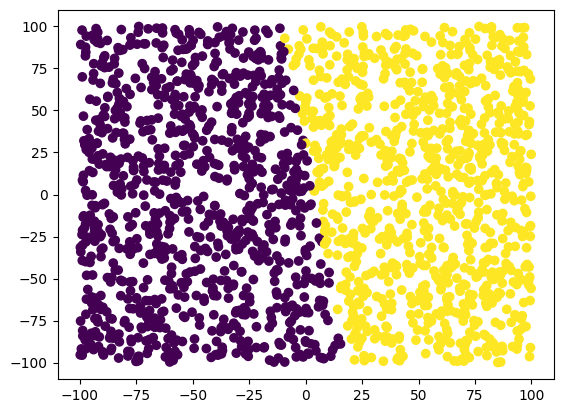

In [476]:
PlotData(X,pred>.5)

## Artificial Neural Network

## Zeros initialization

In [506]:
ModelGraph = nx.Graph()

Model = Sequential([

        fullyconnected(n_out=50,In=X),
        activation(),
        fullyconnected(50),
        activation(),
        fullyconnected(2),
        activation(func=Softmax,loop=False)
])
_,pred = Model.eval()[0]
pred 

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       ...,
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [507]:
n_epochs = 10
α = 1

for n in range(n_epochs):
    outid,pred = Model.eval()[0]
    L= CrossEntropy(onehot(y),pred) 
    print('n=',n,'logloss=',L.eval())
    Model.update({outid:α*L.prime()})

n= 0 logloss= 0.6931471805599453
n= 1 logloss= 0.6931471805599453
n= 2 logloss= 0.6931471805599453
n= 3 logloss= 0.6931471805599453
n= 4 logloss= 0.6931471805599453
n= 5 logloss= 0.6931471805599453
n= 6 logloss= 0.6931471805599453
n= 7 logloss= 0.6931471805599453
n= 8 logloss= 0.6931471805599453
n= 9 logloss= 0.6931471805599453


In [519]:
Model.steps[-2].In[0].Δ

array([[-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0.13175737],
       [-0

In [246]:
_,pred = Model.eval()[0]
pred.min(),pred.max()

(0.2047245875731915, 0.4111125045133907)

## Xavier & He initialization
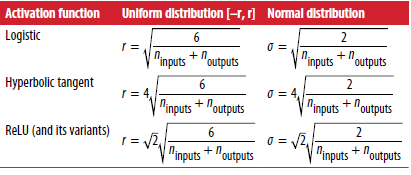

In [247]:
def XHsigmoid(n_in,n_out):
    r = (6/(n_in+n_out))**.5
    return numpy.random.uniform(low=-r,high=r,size=(n_in+1,1))

In [252]:
ModelGraph = nx.Graph()

Model = Sequential([

        fullyconnected(n_out=50,In=(X-X.mean())/X.std(),init_method=XHsigmoid),
        activation(),
        fullyconnected(50,init_method=XHsigmoid),
        activation(),
        fullyconnected(1,init_method=XHsigmoid),
        activation()

])

In [253]:
n_epochs = 3000
α = .03

for n in range(n_epochs):
    outid,pred = Model.eval()[0]
    L= binaryCrossEntropy(y,pred) 
    print('n=',n,'logloss=',L.eval())
    Model.update({outid:α*L.prime()})

n= 0 logloss= 0.8250478563061954
n= 1 logloss= 0.76080949106754
n= 2 logloss= 0.7448193317123262
n= 3 logloss= 0.7367702204003039
n= 4 logloss= 0.73135628690284
n= 5 logloss= 0.7271861902328188
n= 6 logloss= 0.7237213422167139
n= 7 logloss= 0.7207049265705946
n= 8 logloss= 0.7179972643210285
n= 9 logloss= 0.7155151125214553
n= 10 logloss= 0.7132053901750205
n= 11 logloss= 0.7110324317021774
n= 12 logloss= 0.7089712492752617
n= 13 logloss= 0.707003724220268
n= 14 logloss= 0.7051163345947158
n= 15 logloss= 0.7032987376035909
n= 16 logloss= 0.7015428516196746
n= 17 logloss= 0.6998422425114501
n= 18 logloss= 0.6981917019867176
n= 19 logloss= 0.69658695085562
n= 20 logloss= 0.6950244257620081
n= 21 logloss= 0.6935011230156716
n= 22 logloss= 0.6920144823137195
n= 23 logloss= 0.6905622988543788
n= 24 logloss= 0.6891426560037395
n= 25 logloss= 0.687753873069408
n= 26 logloss= 0.6863944643333635
n= 27 logloss= 0.6850631065834448
n= 28 logloss= 0.6837586131348427
n= 29 logloss= 0.682479912861074

In [254]:
_,pred = Model.eval()[0]
pred.min(),pred.max()

(0.2767160273757526, 0.2988692418744494)

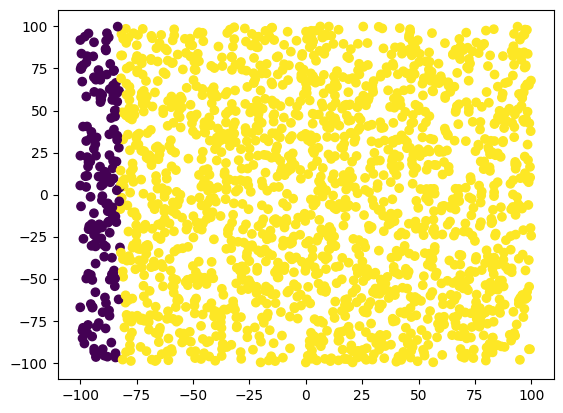

In [255]:
_,pred = Model.eval()[0]
PlotData(X,pred>.28)

## Non saturating activation functions

### Leaky Relu
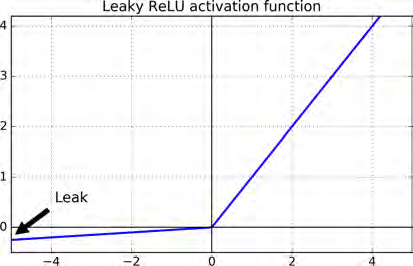

In [256]:
class LeakyRelu(GraphManager):
    def __init__(self,In=None,α=0.01):
        super().__init__()
        self.In = In
        self.α = α
    def eval(self):
        out = lambda : numpy.maximum(self.α*self.In[1],self.In[1])
        self.outid,self.out = self.add_to_graph((self.In[0],out())) 
        return (self.outid,self.out)
    def prime(self):
        I1 = numpy.ones(self.out.shape)
        self.p = numpy.maximum(self.α*I1,I1)
        return self.p
    def update(self,Δnext):
        self.Δ = Δnext*self.prime()
        return self.Δ    

In [259]:
ModelGraph = nx.Graph()

Model = Sequential([

        fullyconnected(n_out=50,In=(X-X.mean())/X.std(),init_method=XHsigmoid),
        activation(func=LeakyRelu),
        fullyconnected(50,init_method=XHsigmoid),
        activation(func=LeakyRelu),
        fullyconnected(1,init_method=XHsigmoid),
        activation()

])

In [260]:
n_epochs = 3000
α = .3

for n in range(n_epochs):
    outid,pred = Model.eval()[0]
    L= MSE(y,pred) 
    print('n=',n,'mse=',L.eval())
    Model.update({outid:α*L.prime()})

n= 0 mse= 0.29092867077304474
n= 1 mse= 0.2832416098440177
n= 2 mse= 0.27777098327668764
n= 3 mse= 0.27263560568081097
n= 4 mse= 0.26782775021879224
n= 5 mse= 0.26333722556835454
n= 6 mse= 0.25915190521608167
n= 7 mse= 0.2552582229536791
n= 8 mse= 0.25164162122553274
n= 9 mse= 0.2482869446056789
n= 10 mse= 0.24517877534736726
n= 11 mse= 0.2423021799558447
n= 12 mse= 0.23965939270540595
n= 13 mse= 0.2372200447182026
n= 14 mse= 0.2349422293289973
n= 15 mse= 0.23283831390442167
n= 16 mse= 0.23089573792765888
n= 17 mse= 0.22910213270244048
n= 18 mse= 0.2274460690284224
n= 19 mse= 0.2259168427188074
n= 20 mse= 0.2245044712582553
n= 21 mse= 0.22319975020636726
n= 22 mse= 0.22199408251304134
n= 23 mse= 0.22087959733034754
n= 24 mse= 0.21984902144090188
n= 25 mse= 0.21889564650083568
n= 26 mse= 0.21801332685324815
n= 27 mse= 0.21719638163410684
n= 28 mse= 0.21643961845577317
n= 29 mse= 0.21573827289376937
n= 30 mse= 0.21508798092479187
n= 31 mse= 0.21448471013317058
n= 32 mse= 0.21392476715564

In [261]:
_,pred = Model.eval()[0]
pred.min(),pred.max()

(0.2901125409111534, 0.2901499635121353)

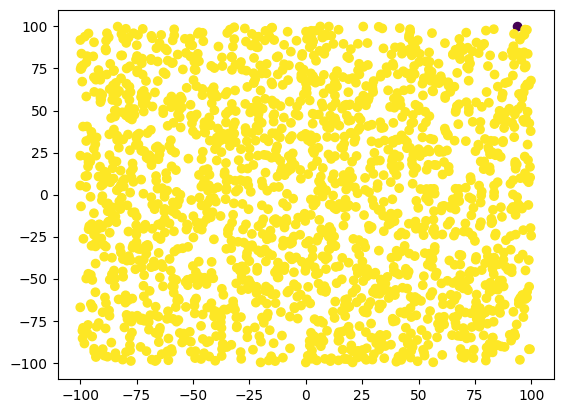

In [262]:
PlotData(X,pred>0.2901125409111534)